In [3]:
import os
import json
import pickle

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold

In [51]:
class MovieLensRecommenderSystem():
    
    
    def read_data(self, path):
        data = pd.read_csv(path, delimiter = '\t', header = None).rename(columns = {0: 'user', 1: 'movie', 2: 'rating'})
        return data
    
    
    def get_similarity_matrix(self, data):
        # Calculates cosine similarity between every pair of rows in the matrix data
        ret = data.dot(data.T)
        lens = np.power(np.matrix.diagonal(ret), 1 / 2)
        
        ret = (ret.T / lens).T
        ret = ret.T
        ret = (ret.T / lens).T
        ret = ret.T
        
        return ret
    
    
    def compute_laplacian(self, adjacency: np.ndarray, normalize: bool = True):
        """ Return:
            L (n x n ndarray): combinatorial or symmetric normalized Laplacian.
        """
        assert (adjacency - adjacency.T).min(axis = 0).min(axis = 0) == 0

        W = adjacency
        deg = W.sum(axis = 0)
        D = np.diag(deg)

        # Combinatorial Laplacian
        L = D - W

        # Normalized Laplacian
        Dn = np.sqrt(np.linalg.inv(D))
        Ln = Dn.dot(L).dot(Dn)

        return Ln if normalize else L
    
    
    def spectral_decomposition(self, laplacian: np.ndarray):
        """ Return:
            lamb (np.array): eigenvalues of the Laplacian
            U (np.ndarray): corresponding eigenvectors.
        """
        R = laplacian
        lamb, U = np.linalg.eigh(R)    
        return lamb, U
    
    
    def number_of_connected_components(self, lamb: np.array, threshold: float = 1e-10):
        """ lamb: array of eigenvalues of a Laplacian
            Return:
            n_components (int): number of connected components.
        """
        return np.sum((lamb < threshold).astype(int))
    
    
    def fit_polynomial(self, lam: np.ndarray, order: int, spectral_response: np.ndarray):
        """ Return an array of polynomial coefficients of length 'order'."""
        V = np.vander(lam, order + 1, increasing = True)
        return np.linalg.lstsq(V, spectral_response, rcond = None)[0]
    
    
    def polynomial_graph_filter_response(self, coeff: np.array, lam: np.ndarray):
        """ Return an array of the same shape as lam.
            response[i] is the spectral response at frequency lam[i]. """
        V = np.vander(lam, coeff.shape[0], increasing = True)
        return V.dot(coeff)

    
    def polynomial_graph_filter(self, coeff: np.array, laplacian: np.ndarray):
        """ Return the laplacian polynomial with coefficients 'coeff'. """
        return sum(coeff[i] * np.linalg.matrix_power(laplacian, i) for i in range(len(coeff)))
    
    
    def __init__(self, train_data_path, seed = 17):
        # Set parameters
        self.DATA_DIR = 'ml-100k/'
        self.train_data_path = train_data_path
        self.seed = seed
        
        # Read the data
        self.train_df = self.read_data(os.path.join(self.DATA_DIR, self.train_data_path))
        self.movie_df = pd.read_csv(os.path.join(self.DATA_DIR, 'u.item'), delimiter = '|',
                                    header = None, encoding = 'latin1') \
                          .drop(columns = [2, 3, 4]).rename(columns = {0: 'movie', 1: 'title'})
        
        # Find list of unique user IDs
        self.inv_map_users = list(set(self.train_df['user']))
        self.num_users = len(self.inv_map_users)

        # Find lsit of unique movie IDs
        self.inv_map_movies = list(set(self.train_df['movie']))
        self.num_movies = len(self.inv_map_movies)
        
        # Find mapping of the original user ID to [0, N - 1]
        self.map_users = {x: i for i, x in enumerate(self.inv_map_users)}
        self.map_movies = {x: i for i, x in enumerate(self.inv_map_movies)}
        
        # Apply the mapping on the actual data
        self.train_df['user'] = self.train_df['user'].apply(lambda x: self.map_users[x])
        self.train_df['movie'] = self.train_df['movie'].apply(lambda x: self.map_movies[x])
        self.movie_df['movie'] = self.movie_df['movie'].apply(lambda x: self.map_movies[x])
        
        
        # Compute statistics
        self.user_mean = self.train_df.groupby('user')['rating'].mean()
        self.user_std = self.train_df.groupby('user')['rating'].std()
        self.movie_mean = self.train_df.groupby('movie')['rating'].mean()
        self.movie_std = self.train_df.groupby('movie')['rating'].std()
        
        # Create users graph
        self.user_repr = np.zeros((self.num_users, self.num_movies))
        for u, i, r in zip(self.train_df['user'], self.train_df['movie'], self.train_df['rating']):
            self.user_repr[u, i] = (r - self.user_mean[u]) / self.user_std[u] # or do not really have to add / std, result is the same
        
        self.user_similarity = self.get_similarity_matrix(self.user_repr)
        self.user_similarity -= np.identity(self.num_users)
        
        c_users = 5.25
        user_mean_similarity = self.user_similarity.mean()
        self.user_adj = (self.user_similarity > c_users * user_mean_similarity).astype(int)
        
        self.user_laplacian_norm = self.compute_laplacian(self.user_adj)
        self.user_lamb_norm, self.user_U_norm = self.spectral_decomposition(self.user_laplacian_norm)
#         print('Number of connected components on users graph: %d' % self.number_of_connected_components(self.user_lamb_norm))
        
#         plt.spy(self.user_adj)
#         plt.show()
        
        # Create filter for users
        self.user_ideal_filter = np.ones(self.num_users)
        self.user_ideal_filter[self.user_lamb_norm >= 0.7] = 0

        self.user_order = 15
        self.user_coeff = self.fit_polynomial(self.user_lamb_norm, self.user_order, self.user_ideal_filter)
        self.user_graph_filter = self.polynomial_graph_filter(self.user_coeff, self.user_laplacian_norm)

#         plt.plot(self.user_lamb_norm, user_ideal_filter)
#         plt.plot(self.user_lamb_norm, self.polynomial_graph_filter_response(user_coeff, self.user_lamb_norm))
#         plt.legend(['Ideal', 'Polynomial'])
#         plt.xlabel('$\lambda$')
#         plt.ylabel('Spectral response')
#         plt.show()
        
        # Create movies graph
        self.movie_adj = np.zeros((self.num_movies, self.num_movies))
        sort_idx = self.movie_mean.to_numpy().argsort()
        for i, j in zip(sort_idx[1:], sort_idx[:-1]):
            self.movie_adj[i, j] = 1
            self.movie_adj[j, i] = 1

        c_movies = 0.20
        for i in range(self.num_movies):
            for j in range(i, self.num_movies):
                if self.movie_adj[i, j] == 0:
                    edge = 1 if abs(self.movie_mean[i] - self.movie_mean[j]) < c_movies else 0
                    self.movie_adj[i, j] = edge
                    self.movie_adj[j, i] = edge

        self.movie_laplacian_norm = self.compute_laplacian(self.movie_adj)
        self.movie_lamb_norm, self.movie_U_norm = self.spectral_decomposition(self.movie_laplacian_norm)
#         print('Number of connected components on movies graph: %d' % self.number_of_connected_components(self.movie_lamb_norm))

#         plt.spy(self.movie_adj)
#         plt.show()
        
        # Create filter for movies
        self.movie_ideal_filter = np.ones(self.num_movies)
        self.movie_ideal_filter[self.movie_lamb_norm >= 0.35] = 0

        self.movie_order = 15
        self.movie_coeff = self.fit_polynomial(self.movie_lamb_norm, self.movie_order, self.movie_ideal_filter)
        self.movie_graph_filter = self.polynomial_graph_filter(self.movie_coeff, self.movie_laplacian_norm)

#         plt.plot(self.movie_lamb_norm, self.movie_ideal_filter)
#         plt.plot(self.movie_lamb_norm, self.polynomial_graph_filter_response(self.movie_coeff, self.movie_lamb_norm))
#         plt.legend(['Ideal', 'Polynomial'])
#         plt.xlabel('$\lambda$')
#         plt.ylabel('Spectral response')
#         plt.show()
        
    
    def predict(self, P, Q, u, i):
        # Predict the rating of user u and movie i
        return P[u].dot(Q[i])
    
    
    def cross_validate(self, n_splits = 5, K = 50, learning_rate = .01, regularization_rate = .017, bias = True, gsp = True, seed = 17):
        # Initialize KFold object
        kf = KFold(n_splits = 5, random_state = seed, shuffle = True)
        
        # Evaluate RMSE for every fold
        total_error = 0
        for it, (train_idx, val_idx) in enumerate(kf.split(self.train_df)):
            # Get the train / validation data
            train_data = self.train_df.loc[train_idx]
            val_data = self.train_df.loc[val_idx]
            
            # Get the RMSE for the it-th fold
            print('Fold: %d/%d' % (it + 1, n_splits))
            cur_error, P, Q = self.evaluate_matrix_factorization(train_data, val_data, K = K, learning_rate = learning_rate, bias = bias,
                                                           gsp = gsp, learn_max_it = 50, filter_max_it = 10,
                                                           regularization_rate = regularization_rate, seed = seed)
            print()
            
            # Get the total error (squared errors)
            total_error += np.power(cur_error, 2) * len(val_data)
        
        # Calculate the total RMSE for all n-folds (weighted, useful if the validation datasets have different sizes)
        final_error = np.power(total_error / len(self.train_df), 1 / 2)
        print('Error: %.5f' % final_error)
    
    
    def learning_step(self, train_data, val_data, P, Q, K, learning_rate, regularization_rate, bias):
        # For every entry in the training data
        for u, i, r in zip(train_data['user'], train_data['movie'], train_data['rating']):
            # Get the prediction, and error
            r_pred = self.predict(P, Q, u, i)
            e_ui = r - r_pred

            # Find the updates for the approriate rows in P and Q
            nP_u = P[u] + learning_rate * (e_ui * Q[i] - regularization_rate * P[u])
            nQ_i = Q[i] + learning_rate * (e_ui * P[u] - regularization_rate * Q[i])

            # Set the approriate element to be 1 for the bias
            if bias:
                nP_u[K] = 1
                nQ_i[K + 1] = 1

            # Update the matrices
            P[u] = nP_u
            Q[i] = nQ_i

        # Calculate RMSE on the validation dataset
        error = 0
        for u, i, r in zip(val_data['user'], val_data['movie'], val_data['rating']):
            # Get the prediction, and error
            r_pred = self.predict(P, Q, u, i)
            e_ui = r - r_pred

            # Error squared
            error += np.power(e_ui, 2)
        # Final RMSE
        error = np.power(error / len(val_data), 1 / 2)
        
        return error, P, Q
    
    
    def learn(self, train_data, val_data, P, Q, K, learning_rate, regularization_rate, bias, max_it):
        # Perform SGD on P, Q until RMSE on the validation dataset increases
        error = 1e9
        for it in range(max_it):
            nP, nQ = P.copy(), Q.copy()
            cur_error, nP, nQ = x.learning_step(train_data, val_data, nP, nQ, K, learning_rate, regularization_rate, bias)

            # print('Learn  it: %3d\t%.5f' % (it, cur_error))
            # If RMSE on validation dataset increases, stop the learning
            if cur_error >= error:
                break

            error = cur_error
            P, Q = nP.copy(), nQ.copy()
        
        # print('-------------------------')
        # print('Final learn it: %3d\t%.5f\n' % (it, error))
        
        return error, P, Q
    
    
    def user_learn(self, train_data, val_data, P, Q, K, learning_rate, regularization_rate, bias, gsp, learn_max_it, filter_max_it):
        error, P, Q = x.learn(train_data, val_data, P, Q, K, learning_rate, regularization_rate, bias, learn_max_it)
        
        if gsp:
            for it in range(filter_max_it):
                nP, nQ = P.copy(), Q.copy()
                nP[:, :K] = self.user_graph_filter.dot(nP[:, :K])
                cur_error, nP, nQ = x.learn(train_data, val_data, nP, nQ, K, learning_rate / 10, regularization_rate, bias, learn_max_it)

                # print('\tuser_learn it: %3d\t%.5f\n\n' % (it, cur_error))
                if cur_error >= error:
                    break

                error = cur_error
                P, Q = nP.copy(), nQ.copy()
            
            # print('\t-------------------')
            # print('\tFinal user_learn it: %3d\t%.5f\n' % (it, error))
        
        return error, P, Q

    
    def evaluate_matrix_factorization(self, train_data, val_data, P = None, Q = None, K = 50, learning_rate = .01, regularization_rate = .017, bias = True, gsp = True, learn_max_it = 50, filter_max_it = 10, seed = 17):
        np.random.seed(seed)
        
        # Latent space dimension
        dim = K + (2 if bias else 0)
        
        if P is None:
            # Initialize matrices P, Q ... the embeddings of the user and movies
            P = np.random.choice([-0.01, 0.01], size = self.num_users * dim).reshape((self.num_users, dim))
            
            if bias:
                P[:, K] = 1
        
        if Q is None:
            Q = np.random.choice([-0.01, 0.01], size = self.num_movies * dim).reshape((self.num_movies, dim))
        
            # Initialize one column to be 1 so that we can learn the bias
            if bias:
                Q[:, K + 1] = 1
        
        error, P, Q = self.user_learn(train_data, val_data, P, Q, K, learning_rate, regularization_rate, bias, gsp, learn_max_it, filter_max_it)
        
        if gsp:
            for it in range(filter_max_it):
                nP, nQ = P.copy(), Q.copy()
                nQ[:, :K] = self.movie_graph_filter.dot(nQ[:, :K])
                cur_error, nP, nQ = self.user_learn(train_data, val_data, nP, nQ, K, learning_rate, regularization_rate, bias, gsp, learn_max_it, filter_max_it)

                print('movie_learn it: %3d\t%.5f\n\n' % (it, cur_error))
                if cur_error >= error:
                    break

                error = cur_error
                P, Q = nP.copy(), nQ.copy()
            
            print('-------------------')
            print('Final movie_learn it: %3d\t%.5f\n' % (it, error))
        
        return error, P, Q

In [52]:
x = MovieLensRecommenderSystem('u.data')
#error, P, Q = x.evaluate_matrix_factorization(train, test, gsp = True);

In [ ]:
error, P, Q = x.evaluate_matrix_factorization(train, test, gsp = True);

In [53]:
x.cross_validate(learning_rate = .01, regularization_rate = .051, bias = True, gsp = True, seed = 17)

Fold: 1/5
movie_learn it:   0	0.87820


movie_learn it:   1	0.87667


movie_learn it:   2	0.87583


movie_learn it:   3	0.87533


movie_learn it:   4	0.87507


movie_learn it:   5	0.87494


movie_learn it:   6	0.87491


movie_learn it:   7	0.87491


-------------------
Final movie_learn it:   7	0.87491


Fold: 2/5
movie_learn it:   0	0.88177


movie_learn it:   1	0.88116


movie_learn it:   2	0.88069


movie_learn it:   3	0.88039


movie_learn it:   4	0.88021


movie_learn it:   5	0.88014


movie_learn it:   6	0.88014


movie_learn it:   7	0.88016


-------------------
Final movie_learn it:   7	0.88014


Fold: 3/5
movie_learn it:   0	0.88056


movie_learn it:   1	0.87939


movie_learn it:   2	0.87860


movie_learn it:   3	0.87810


movie_learn it:   4	0.87781


movie_learn it:   5	0.87767


movie_learn it:   6	0.87762


movie_learn it:   7	0.87761


movie_learn it:   8	0.87766


-------------------
Final movie_learn it:   8	0.87761


Fold: 4/5
movie_learn it:   0	0.88630


movie_learn 

In [ ]:
# movie_adj = np.zeros((x.num_movies, x.num_movies))

# movie_avg_grade = x.train_df.groupby('movie')['rating'].mean().to_numpy()
# sort_idx = movie_avg_grade.argsort()
# for i, j in zip(sort_idx[1:], sort_idx[:-1]):
#     movie_adj[i, j] = 1
#     movie_adj[j, i] = 1

# c = 0.20
# for i in range(x.num_movies):
#     for j in range(i, x.num_movies):
#         if movie_adj[i, j] == 0:
#             edge = 1 if abs(movie_avg_grade[i] - movie_avg_grade[j]) < c else 0
#             movie_adj[i, j] = edge
#             movie_adj[j, i] = edge

# movie_laplacian_norm = x.compute_laplacian(movie_adj)
# movie_lamb_norm, movie_U_norm = x.spectral_decomposition(movie_laplacian_norm)
# print('Number of connected components on users graph: %d' % x.number_of_connected_components(movie_lamb_norm))
        
# plt.spy(movie_adj)
# plt.show()

# movie_ideal_filter = np.ones(x.num_movies)
# movie_ideal_filter[movie_lamb_norm >= 0.35] = 0

# movie_order = 15
# movie_coeff = x.fit_polynomial(movie_lamb_norm, movie_order, movie_ideal_filter)
# movie_graph_filter = x.polynomial_graph_filter(movie_coeff, movie_laplacian_norm)

# plt.plot(movie_lamb_norm, movie_ideal_filter)
# plt.plot(movie_lamb_norm, x.polynomial_graph_filter_response(movie_coeff, movie_lamb_norm))
# plt.legend(['Ideal', 'Polynomial'])
# plt.xlabel('$\lambda$')
# plt.ylabel('Spectral response')
# plt.show()

nQ = Q.copy()
nQ[:, :50] = x.movie_graph_filter.dot(nQ[:, :50])

error, nP, nQ = x.evaluate_matrix_factorization(train, test, P = P, Q = nQ, gsp = True);

Number of connected components on users graph: 1


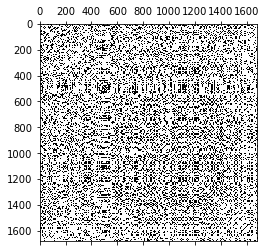

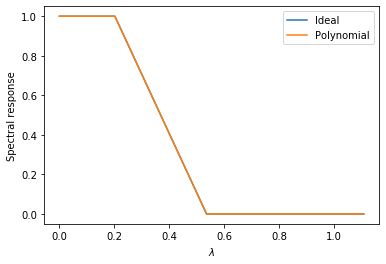

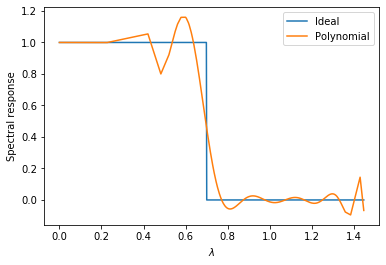

Learn  it:   0	0.90012
Learn  it:   1	0.89160
Learn  it:   2	0.88700
Learn  it:   3	0.88419
Learn  it:   4	0.88255
Learn  it:   5	0.88181
Learn  it:   6	0.88182
-------------------------
Final learn it:   6	0.88181

Learn  it:   0	0.88669
Learn  it:   1	0.88569
Learn  it:   2	0.88487
Learn  it:   3	0.88418
Learn  it:   4	0.88358
Learn  it:   5	0.88305
Learn  it:   6	0.88258
Learn  it:   7	0.88215
Learn  it:   8	0.88177
Learn  it:   9	0.88142
Learn  it:  10	0.88109
Learn  it:  11	0.88080
Learn  it:  12	0.88052
Learn  it:  13	0.88027
Learn  it:  14	0.88004
Learn  it:  15	0.87982
Learn  it:  16	0.87962
Learn  it:  17	0.87944
Learn  it:  18	0.87927
Learn  it:  19	0.87911
Learn  it:  20	0.87896
Learn  it:  21	0.87883
Learn  it:  22	0.87871
Learn  it:  23	0.87859
Learn  it:  24	0.87849
Learn  it:  25	0.87840
Learn  it:  26	0.87832
Learn  it:  27	0.87824
Learn  it:  28	0.87818
Learn  it:  29	0.87812
Learn  it:  30	0.87808
Learn  it:  31	0.87804
Learn  it:  32	0.87800
Learn  it:  33	0.87798
Le

In [30]:
movie_similarity = x.get_similarity_matrix(Q[:, :50])
movie_similarity -= np.identity(x.num_movies)
        
c_movies = 67 #132
movie_mean_similarity = movie_similarity.mean()
movie_adj = (movie_similarity > c_movies * movie_mean_similarity).astype(int)
        
movie_laplacian_norm = x.compute_laplacian(movie_adj)
movie_lamb_norm, movie_U_norm = x.spectral_decomposition(movie_laplacian_norm)
print('Number of connected components on users graph: %d' % x.number_of_connected_components(movie_lamb_norm))
        
plt.spy(movie_adj)
plt.show()


movie_ideal_filter = np.ones(x.num_movies)
movie_ideal_filter[movie_lamb_norm >= 0.35] = 0

movie_order = 15
movie_coeff = x.fit_polynomial(movie_lamb_norm, movie_order, movie_ideal_filter)
movie_graph_filter = x.polynomial_graph_filter(movie_coeff, movie_laplacian_norm)

plt.plot(movie_lamb_norm, movie_ideal_filter)
plt.plot(movie_lamb_norm, x.polynomial_graph_filter_response(movie_coeff, movie_lamb_norm))
plt.legend(['Ideal', 'Polynomial'])
plt.xlabel('$\lambda$')
plt.ylabel('Spectral response')
plt.show()

nQ = Q.copy()
nQ[:, :50] = movie_graph_filter.dot(nQ[:, :50])

error, nP, nQ = x.evaluate_matrix_factorization(train, test, P = P, Q = nQ, gsp = True);

In [ ]:
ideal_filter = np.ones(x.num_users)
ideal_filter[x.user_lamb_norm >= 0.7] = 0
#ideal_filter[x.user_lamb_norm >= 1.1] = 1

In [ ]:
order = 15

coeff = x.fit_polynomial(x.user_lamb_norm, order, ideal_filter)
graph_filter = x.polynomial_graph_filter(coeff, x.user_laplacian_norm)

In [ ]:
plt.plot(x.user_lamb_norm, ideal_filter)
plt.plot(x.user_lamb_norm, x.polynomial_graph_filter_response(coeff, x.user_lamb_norm))
plt.legend(['Ideal', 'Polynomial'])
plt.xlabel('$\lambda$')
plt.ylabel('Spectral response')

In [6]:
train = x.train_df[['user', 'movie', 'rating']].sample(frac = 1, random_state = 17)[:80000]
test = x.train_df[['user', 'movie', 'rating']].sample(frac = 1, random_state = 17)[80000:]
#error, P, Q = x.evaluate_matrix_factorization(train, test)

In [ ]:
P[:, :50] = graph_filter @ P[:, :50]

In [ ]:
error, nP, nQ = x.evaluate_matrix_factorization(train, test, P = P, Q = Q)

In [ ]:
for i in range(10):
    print('i: %d' % i)
    nP[:, :50] = graph_filter @ nP[:, :50]
    error, nP, nQ = x.evaluate_matrix_factorization(train, test, P = nP, Q = nQ)

In [ ]:
nP[:, :50] = graph_filter @ nP[:, :50]

In [ ]:
error, nP, nQ = x.evaluate_matrix_factorization(train, test, P = nP, Q = nQ)

In [ ]:
yy = x.movie_mean.value_counts().index
yy.argsort()
zz = yy[yy.argsort()]
zz
#((zz[1:] - zz[:-1]) > 0.2).astype(int)

In [ ]:
srt = x.user_similarity[152].argsort()[::-1]
print(srt)
x.user_similarity[152][srt]

In [ ]:
movies_new_df[movies_new_df['imdbRating'] == 'N/A']

In [ ]:
data_df[data_df['user'].isin([1, 773, 868])].groupby('movie')['user'].apply(list).apply(len).to_numpy().argsort()[::-1]
data_df[data_df['user'].isin([1, 773, 868])].groupby('movie')['user'].apply(list).apply(len).value_counts()

In [ ]:
data_df[data_df['user'].isin([1, 773, 868]) & data_df['movie'].isin([332])]

In [ ]:
data_df[data_df['movie'].isin([1682])]